# Dataset

## Original Format

### Load Data

In [19]:
import os
import pathlib
import json
import numpy as np
from PIL import Image, ImageDraw as Drawer
import matplotlib.pyplot as plt
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2 import model_zoo
from ignite.handlers import FastaiLRFinder
import torch

# path to the satcen dataset
satcen_path = pathlib.Path('../satcen_dataset/full').resolve()

In [20]:
# load the full Satcen dataset
satcen = os.listdir(satcen_path/'pictures')

# load the labels (bounding boxes)
labels_file = open(satcen_path/'labels.json')
labels_json = json.load(labels_file)

# define a helper function that returns the list of bounding boxes given a filename
def get_bounding_boxes(filename):
    return list(filter(lambda x: x['name'] == filename, labels_json))[0]['bounding_boxes']

# convert the bounding boxes into binary labels 0/1
y = np.array([])
for img in satcen:

    bounding_boxes = get_bounding_boxes(img)
    y = np.append(y, 1 if len(bounding_boxes) > 0 else 0)

# print info about entire dataset
print(f'Total number of Satcen images: {len(satcen)}')
print(f'Total number of labels (annotations): {len(labels_json)}')
print(f'Number of positive observations: {np.sum(y==1)} ({100 * np.sum(y==1) / len(y):.2f}%)')
print(f'Number of negative observations: {np.sum(y==0)} ({100 * np.sum(y==0) / len(y):.2f}%)\n')

# load the data
train_images = os.listdir(satcen_path/'splits/train/images')
valid_images = os.listdir(satcen_path/'splits/validation/images')
test_images = os.listdir(satcen_path/'splits/test/images')

# compute binary labels for each set
y_train = np.array([y[satcen.index(img)] for img in train_images])
y_valid = np.array([y[satcen.index(img)] for img in valid_images])
y_test = np.array([y[satcen.index(img)] for img in test_images])

# print stats about the splits
print('Train dataset')
print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

print('\nValidation dataset')
print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

print('\nTest dataset')
print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

Total number of Satcen images: 9420
Total number of labels (annotations): 9420
Number of positive observations: 1525 (16.19%)
Number of negative observations: 7895 (83.81%)

Train dataset
Size: 5652 (60.00%)
Positive observations: 915 (16.19%)
Negative observations: 4737 (83.81%)

Validation dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)

Test dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)


## Detectron2 Dataset

### Register Datasets

Register **train** and **validation** datasets based on the existing split.

In [21]:
# ds_type can take two possible values: train and valid
def dataset_function(ds_type):

    # determine which dataset to create
    images = []
    if ds_type == 'train':
        images = train_images
    elif ds_type == 'valid':
        images = valid_images
    else:
        raise f'Invalid value for ds_type: {ds_type}'

    # represents the list of dicts
    dataset = []

    # loop through all images
    for i, image in enumerate(images):
        
        # list of annotations for the current image
        annotations = []

        # get the bounding boxes of the image
        bounding_boxes = get_bounding_boxes(image)

        # loop through the bounding boxes
        for bb in bounding_boxes:
            
            # convert coordinates to required format
            points = np.array([[p['x'], p['y']] for p in bb])

            # get rotated rectangle
            ((cx, cy), (w, h), a) = cv2.minAreaRect(points)

            # store the annotation
            annotations.append({
                'bbox_mode': BoxMode.XYWHA_ABS,
                'bbox': (cx, cy, w, h, -a),
                'category_id': 0 # skiff
            })
        
        # store the image in the dataset
        dataset.append({
            'file_name': satcen_path/'pictures'/image,
            'height': 256,
            'width': 256,
            'image_id': i,
            'annotations': annotations
        })

    return dataset

# register training dataset
if 'satcen_train' in DatasetCatalog.keys():
    DatasetCatalog.remove('satcen_train')
DatasetCatalog.register('satcen_train', lambda x='train': dataset_function(x))

# register validation dataset
if 'satcen_valid' in DatasetCatalog.keys():
    DatasetCatalog.remove('satcen_valid')
DatasetCatalog.register('satcen_valid', lambda x='valid': dataset_function(x))

# set metadata for the datasets
MetadataCatalog.get('satcen_train').thing_classes = ['skiff']
MetadataCatalog.get('satcen_valid').thing_classes = ['skiff']

### Show Examples

Show examples of the images from the original dataset and from the Detectron2 dataset to ensure the entries are formatted correctly.

In [22]:
# get the detectron2 dataset
train_dataset = dataset_function('train')
train_medatadata = MetadataCatalog.get('satcen_train')

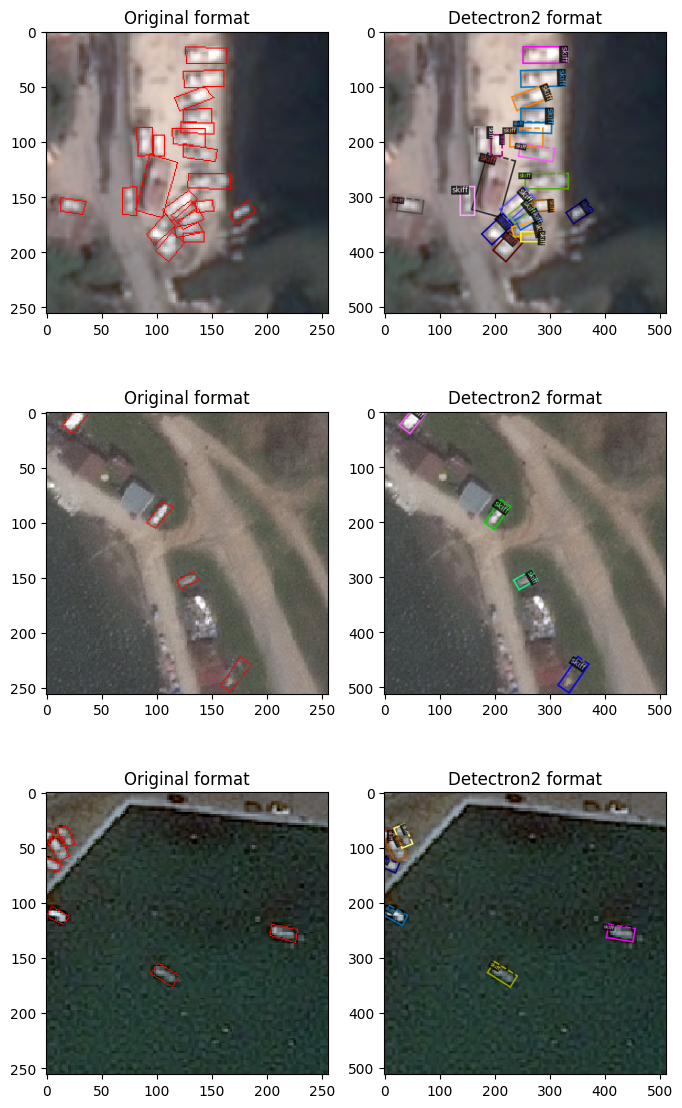

In [23]:
# select only images with ships from the training dataset
train_ship_images = [train_images[i] for i in np.where(y_train==1)[0]]

# list of images to be displayed
images_to_be_displayed = [train_ship_images[110], train_ship_images[12], train_ship_images[348]]

# set up sublots 
plt.subplots(len(images_to_be_displayed), 2, figsize=(8, len(images_to_be_displayed) * 4 + 2))

# display each image
for i, filename in enumerate(images_to_be_displayed):
    
    # get the bounding boxes from the original dataset
    bounding_boxes = get_bounding_boxes(filename)
    
    # open the image
    img = Image.open(satcen_path/'pictures'/filename)
    
    # draw each bounding box
    draw = Drawer.Draw(img)
    for bb in bounding_boxes:

        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bb]

        # draw polygon
        draw.polygon(coords, outline=(255,0,0))

    # display the image using original format
    plt.subplot(len(images_to_be_displayed), 2, 2*i+1)
    plt.title('Original format')
    plt.imshow(img)

    # filter the dataset (list of dicts)
    filtered_dict = list(filter(lambda x: x['file_name'] == satcen_path/'pictures'/filename, train_dataset))
    if len(filtered_dict) == 0: 
        raise f'Could not find corresponding file in detectron2 dataset: {filename}'
    entry = filtered_dict[0]

    # draw bounding boxes on image
    img = cv2.imread(str(entry['file_name']))
    visualizer = Visualizer(img[:, :, ::-1], train_medatadata, scale=2)
    out = visualizer.draw_dataset_dict(entry)

    # display the image using detectron2 format
    plt.subplot(len(images_to_be_displayed), 2, 2*i+2)
    plt.title('Detectron2 format')
    plt.imshow(out.get_image())

plt.show()


# Training

## Construct the Model

### Define the Model Architecture

In [24]:
# get config
cfg = get_cfg()

# get base model
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))

# get the pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')

# set the train and test (validation) datasets
cfg.DATASETS.TRAIN = ('satcen_train',)
cfg.DATASETS.TEST = ('satcen_valid',)

# set the number of classes to be predicted
# we only have 1 class (skiff)
# background is not considered as class
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# use RRPN as the proposal generator
cfg.MODEL.PROPOSAL_GENERATOR.NAME = 'RRPN'

# ROI head
cfg.MODEL.ROI_HEADS.NAME = 'RROIHeads'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # number of ROIs samples from each image

# Box head
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = 'ROIAlignRotated'
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (1,1,1,1,1)

# set the bbox regression weights of the RPN
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (1,1,1,1,1)

# Anchor generator
cfg.MODEL.ANCHOR_GENERATOR.NAME = 'RotatedAnchorGenerator'
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90,-60,-30,0,30,60,90]]

# specify where to save the model
cfg.OUTPUT_DIR = './models'

## Methodology

### Find LR

In [66]:
# use images without skiffs in training
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True

# number of ROIs sampled from each image during training
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# number of images per batch/iteration (actual batch size)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate

# get the training dataloader
dataloader = build_detection_train_loader(cfg)

[03/09 14:48:50 d2.data.build]: Removed 4737 images with no usable annotations. 915 images left.
[03/09 14:48:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/09 14:48:50 d2.data.build]: Using training sampler TrainingSampler
[03/09 14:48:50 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/09 14:48:50 d2.data.common]: Serializing 915 elements to byte tensors and concatenating them all ...
[03/09 14:48:50 d2.data.common]: Serialized dataset takes 1.33 MiB


In [30]:
# get the model from the config
model = build_model(cfg)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

lr_finder = FastaiLRFinder()

In [67]:
model.train()
model.to(torch.device('cuda'))
# print(model.proposal_generator.box2box_transform.get_deltas(torch.tensor([(1,1,1,1,1)]),torch.tensor([(1,1,12,1,1)])))

example = next(iter(zip(dataloader)))[0]
from detectron2.utils.events import EventStorage

import traceback
import sys

try:
    with EventStorage(10) as storage:
    
        # print(model.proposal_generator.box2box_transform.get_deltas(torch.tensor([(1,1,1,1,1)]),torch.tensor([(1,1,12,1,1)])))
        loss_dict = model([example[0]])
    # print(loss_dict)
except Exception:
    print(traceback.format_exc())
    # or
    print(sys.exc_info()[2])



Traceback (most recent call last):
  File "/tmp/ipykernel_6358/4220209017.py", line 15, in <module>
    loss_dict = model([example[0]])
  File "/home/tudor/satcen-ship-detection/detectron2_env/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1533, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/tudor/satcen-ship-detection/detectron2_env/lib/python3.8/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 161, in forward
    proposals, proposal_losses = self.proposal_generator(images, features, gt_instances)
  File "/home/tudor/satcen-ship-detection/detectron2_env/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1533, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/tudor/satcen-ship-detection/detectron2_env/lib/python3.8/site-packages/detectron2/modeling/proposal_generator/rpn.py", line 472, in forward
    losses = self.losses(
  File "/home/tudor/satcen-ship-detection/detectron2_env/lib/python3.8/site-packages/dete